# 가정
국가는 **아랍에미리트**, 이커머스 사이트를 **아마존**이라고 가정

- 참고링크1 : https://blog.naver.com/fedex_kr/222697326719
- 참고링크2 : https://blog.naver.com/dhzhdapxk/222279313175

아랍에미리트의 전자상거래시장의 성장률을 19년도 이후부터 상승하고 있으며,  
2017년도 7월 중동 최대 온라인 쇼핑몰인 수크 닷컴을 아마존에서 인수하였음.

# 라이브러리 로드

In [1]:
!pip install fastparquet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 25.2 MB/s 
     |████████████████████████████████| 1.6 MB 52.3 MB/s 


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 로드

In [4]:
try:
  path = 'C:/Users/User/Desktop/AIB_13/CP2/data/'
  df = pd.read_parquet(path + 'light_2019-Oct.parquet', engine='fastparquet')
except:
  path = '/content/drive/MyDrive/CP2/data/'
  df = pd.read_parquet(path + 'light_2019-Oct.parquet', engine='fastparquet')

df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,-251657396,NaN,shiseido,35.790001,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,-780140327,appliances.environment.water_heater,aqua,33.200001,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,-1904213353,furniture.living_room.sofa,NaN,543.099976,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,1518338663,computers.notebook,lenovo,251.740005,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,-1769995873,electronics.smartphone,apple,1081.979980,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


## 혹시 모를경우를 대비하여 df 복사

In [5]:
copy_df = df.copy()
copy_df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,-251657396,NaN,shiseido,35.790001,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,-780140327,appliances.environment.water_heater,aqua,33.200001,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,-1904213353,furniture.living_room.sofa,NaN,543.099976,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,1518338663,computers.notebook,lenovo,251.740005,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,-1769995873,electronics.smartphone,apple,1081.979980,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


# 데이터 확인

In [6]:
copy_df.isnull().sum()

event_time              0
event_type              0
product_id              0
category_id             0
category_code    13515609
brand             6117080
price                   0
user_id                 0
user_session            2
dtype: int64

category_code와 brand 컬럼의 결측치가 존재하는 것으로 확인됩니다.

In [7]:
copy_df.isnull().sum() / len(copy_df) * 100

event_time        0.000000
event_type        0.000000
product_id        0.000000
category_id       0.000000
category_code    31.839818
brand            14.410502
price             0.000000
user_id           0.000000
user_session      0.000005
dtype: float64

결측치는
- **category_code : 31%**
- **brand : 14%**

입니다.

## event_time

event_time 컬럼은 현재 `str`로 되어 있습니다.  
1. 2019-10-01 부터 2019-10-31 까지 수집했으며, 맨 뒤에 UTC가 붙어 삭제처리를 해야합니다.
2. 날짜를 쉽게 추출할 수 있도록 datetime으로 변경합니다.

In [8]:
copy_df['event_time'] = copy_df['event_time'].apply(lambda x : x[:-4])

In [9]:
copy_df['event_time'] = pd.to_datetime(copy_df['event_time'])

## event_type
event_time은 사용자가 어떤 행동을 하였는지 확인할 수 있습니다.
- view
- purchase
- cart

In [10]:
copy_df['event_type'].unique()

['view', 'purchase', 'cart']
Categories (3, object): ['cart', 'purchase', 'view']

## product_id
제품의 ID를 나타내고 있습니다.

In [11]:
copy_df['product_id'].nunique()

166794

총 16만개 정도의 제품이 있습니다.

## category_id
category_id 컬럼은 int64-> int32로 경량화 하는 작업으로 인하여  
int32의 양수의 범위를 넘는 데이터는 음수로 바뀐것으로 추측됩니다.

In [12]:
copy_df['category_id'].nunique()

624

총 624개의 category_id가 존재합니다.

## category_code
category_code는 전체 컬럼중 NULL값이 가장 많은 데이터입니다.  
NULL값을 채우는 방법에 따라 결과가 달라질 것으로 추측됩니다.  
- category_id로 결측치를 채울 수 있는 방법이 있을 수 있습니다.

category별로 '.'으로 분리 할 수있는 형태로 보이며, 전처리를 해야할 것 같습니다.

In [13]:
copy_df['category_code'].nunique()

126

아직 '.'을 기준으로 category를 분리하지 않았지만, 126개의 유니크한 값들이 존재합니다.

In [14]:
copy_df.loc[copy_df['category_code'].isnull()]['category_id'].nunique()

372

category_code가 NULL인 값들만 조회했을 때, 유니크한 category_id는 372개 입니다.

In [15]:
copy_df.loc[copy_df['category_code'].isnull()]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00,view,44600062,-251657396,NaN,shiseido,35.790001,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
6,2019-10-01 00:00:08,view,17300353,746586423,NaN,creed,380.959991,555447699,4fe811e9-91de-46da-90c3-bbd87ed3a65d
7,2019-10-01 00:00:08,view,31500053,629146159,NaN,luminarc,41.160000,550978835,6280d577-25c8-4147-99a7-abc6048498d6
13,2019-10-01 00:00:15,view,44600062,-251657396,NaN,shiseido,35.790001,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
15,2019-10-01 00:00:17,view,23100006,-58719491,NaN,NaN,357.790009,513642368,17566c27-0a8f-4506-9f30-c6a2ccbf583b
...,...,...,...,...,...,...,...,...,...
42448750,2019-10-31 23:59:55,view,42200036,1325400745,NaN,NaN,17.500000,515474976,222c370b-0fac-4287-982b-e340f5eaf3a1
42448755,2019-10-31 23:59:58,view,12800151,-318766863,NaN,sony,8.490000,544578298,fb46b2fb-493b-477c-8d18-ea1c24c04020
42448756,2019-10-31 23:59:58,view,5100816,268435735,NaN,xiaomi,29.580000,543653226,ab310b47-1eb2-45f8-8e5b-21ab2010925a
42448760,2019-10-31 23:59:58,view,10800172,1887437177,NaN,redmond,61.750000,527322328,5054190a-46cb-4211-a8f1-16fc1a060ed8


## brand
brand 컬럼 또한 NULL값이 존재하는 컬럼입니다.

In [16]:
copy_df['brand'].nunique()

3444

3천 4백개의 브랜드가 존재합니다.

## price
price 컬럼은 수치형 데이터입니다.

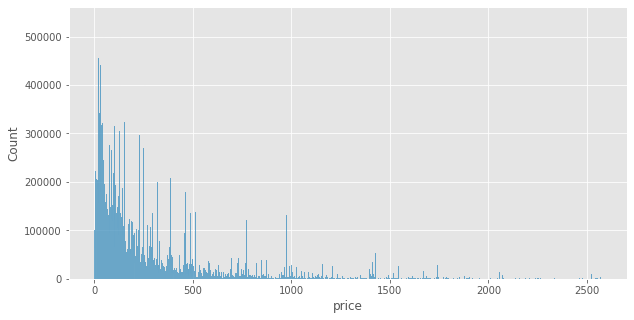

In [17]:
plt.figure(figsize=(10,5))
sns.histplot(data=copy_df, x='price')
plt.show()

## user_id

In [18]:
copy_df['user_id'].nunique()

3022290

약 3백만명의 유저들의 데이터가 수집된 것을 확인할 수 있습니다.

## user_session

In [19]:
copy_df['user_session'].nunique()

9244421

# 전체(10월 한달동안)방문자수는 얼마인가?

In [20]:
copy_df['user_id'].nunique()

3022290

총 3백만명 정도의 유저가 방문한 것으로 확인됩니다.

# 전체(10월 한달동안) 매출액은 얼마인가?

In [21]:
copy_df.loc[copy_df['event_type'] == 'purchase', 'price'].sum()

229957500.0

price의 단위가 달러라고 가정해보았을 때, 약 2억 3천만 달러가 판매가 되었습니다.  
현재 환율로 환산하면, 약 한화로 3,206억원 정도 입니다.

# DAU(일별 활동 이용자)는 평균적으로 몇명인가?

In [22]:
daus = []
for day in tqdm(range(1, 32,1)):
    dau = copy_df.loc[copy_df['event_time'].dt.day == day]['user_id'].nunique()
    daus.append(dau)

100%|██████████| 31/31 [02:11<00:00,  4.25s/it]


In [23]:
print(round(np.mean(daus)))

208830


일별 활동 이용자는 평균적으로 20만명정도 됩니다.

# WAU는 평균적으로 몇명인가?

In [24]:
week1 = copy_df.loc[copy_df['event_time'].dt.day.isin([1,2,3,4,5])]['user_id'].nunique()
week2 = copy_df.loc[copy_df['event_time'].dt.day.isin(list(range(6, 12+1)))]['user_id'].nunique()
week3 = copy_df.loc[copy_df['event_time'].dt.day.isin(list(range(3, 19+1)))]['user_id'].nunique()
week4 = copy_df.loc[copy_df['event_time'].dt.day.isin(list(range(20, 26+1)))]['user_id'].nunique()
week5 = copy_df.loc[copy_df['event_time'].dt.day.isin(list(range(27, 31+1)))]['user_id'].nunique()

print('1주 :',week1)
print('2주 :',week2)
print('3주 :',week3)
print('4주 :',week4)
print('5주 :',week5)
waus = [week1, week2, week3, week4, week5]
print('평균 :',round(np.mean(waus)))

1주 : 734691
2주 : 1047455
3주 : 1989498
4주 : 1111053
5주 : 764234
평균 : 1129386


평균적으로 약 100만명의 사용자가 한주동안 사이트를 이용하며,  
3주에 가장 많은 인원이 이용한 것으로 확인됩니다.
- 왜 3주에 가장 많은 인원이 이용한 것인지는 모르겠음..

# 1인당 평균 매입액(객단가)는 얼마인가?
객단가 : 매출액 / 고객수
- 고객 한명의 평균 매입액

ex) 
- A : 4, 4, 5
- B : 5
- C : 5

객단가 : 76000원 정도((4+4+5+5+5)/3)

In [25]:
user_number = copy_df['user_id'].nunique()
purchase_amount = copy_df.loc[copy_df['event_type'] == 'purchase', 'price'].sum()

result = purchase_amount / user_number
print(result)

76.08717363323838


10월 한달 1인당 평균 매입액(객단가)는 약 76달러로 현재 환율로 환산하면 약 10만원 정도입니다.

# 코호트분석
- 참고링크1(https://workingwithpython.com/pythoncohortanalysis/)

1. 우리 사이트에 들어온 고객들은 우리 사이트를 계속 이용하는가?(사용자 유지율 파악)
  -  view, cart, purchase 모두 포함
2. 우리 사이트에서 구매했던 고객들은 계속 우리 사이트에서 구매를 하는가?
  - purchase만 추출

## 1.사용자 유지율 파악
- 우리 사이트에 들어온 고객들은 우리 사이트를 계속 이용하는가?
- view, cart, purchase 포함

코호트 분석에 사용할 '동일한 경험', '동일한 시간'이 데이터에 표현되도록 

코호트 분석에 사용할 피처만 가지고 오겠습니다.

### 사용할 피처만 가지고 오기

In [27]:
cohort_data = copy_df[['product_id', 'event_time','user_id']]
cohort_data.head()

,product_id,event_time,user_id
0,44600062,2019-10-01 00:00:00,541312140
1,3900821,2019-10-01 00:00:00,554748717
2,17200506,2019-10-01 00:00:01,519107250
3,1307067,2019-10-01 00:00:01,550050854
4,1004237,2019-10-01 00:00:04,535871217


코호트 분석에서 데이터를 집계하기 위해서는 보통 **월 단위**가 진행되지만  
현재 10월의 데이터만 있기 때문에 **일 단위**로 진행하겠습니다.

### 단위기간을 파악하기 위하여 '일'만 가지고 오기

In [31]:
cohort_data['event_period'] = cohort_data['event_time'].dt.day
cohort_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,product_id,event_time,user_id,event_period
0,44600062,2019-10-01 00:00:00,541312140,1
1,3900821,2019-10-01 00:00:00,554748717,1
2,17200506,2019-10-01 00:00:01,519107250,1
3,1307067,2019-10-01 00:00:01,550050854,1
4,1004237,2019-10-01 00:00:04,535871217,1


### 유저의 (10월)첫번째 방문을 토대로 유저별 코호트 그룹 설정하기

코호트 분석의 전제조건 중 '동일한 경험'을 만드는 과정입니다.

여기서 '동일한 경험'이란 (10월)첫 번째 방문입니다.

In [33]:
cohort_data = cohort_data.set_index('user_id')
cohort_data.head()

,product_id,event_time,event_period
user_id,,,
541312140,44600062,2019-10-01 00:00:00,1
554748717,3900821,2019-10-01 00:00:00,1
519107250,17200506,2019-10-01 00:00:01,1
550050854,1307067,2019-10-01 00:00:01,1
535871217,1004237,2019-10-01 00:00:04,1


In [ ]:
pd.to_datetime(cohort_data['event_time'], format='%Y-%m-%d %H:%M:%S', errors='raise')

In [34]:
first_event = cohort_data.groupby('user_id')['event_time'].min()


TypeError: ignored

# 사람들이 어떤 제품을 가장 많이 구매하는가?

event_type 중 purchase만 가져와서 확인하겠습니다.

In [ ]:
purchase = copy_df.loc[copy_df['event_type'] == 'purchase']
purchase.shape

(742849, 9)

In [ ]:
purchase.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
162,2019-10-01 00:02:14,purchase,1004856,-1769995873,electronics.smartphone,samsung,130.759995,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564
308,2019-10-01 00:04:37,purchase,1002532,-1769995873,electronics.smartphone,apple,642.690002,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68
379,2019-10-01 00:06:02,purchase,5100816,268435735,NaN,xiaomi,29.510000,514591159,0e5dfc4b-2a55-43e6-8c05-97e1f07fbb56
442,2019-10-01 00:07:07,purchase,13800054,16777737,furniture.bathroom.toilet,santeri,54.419998,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f
574,2019-10-01 00:09:26,purchase,4804055,1551892843,electronics.audio.headphone,apple,189.910004,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553


In [ ]:
top10_product = purchase['product_id'].value_counts()[:10]

In [ ]:
products = []
for i in range(len(top10_product)):
    product = top10_product.index[i]
    count = top10_product.values[i]
    category_code = purchase.loc[purchase['product_id']==product]['category_code'].unique()[0]
    brand = purchase.loc[purchase['product_id']==product]['brand'].unique()[0]
    
    products.append([product,category_code, brand, count])

In [ ]:
pd.DataFrame(products, columns=['product_id','category_code','brand','count'])

,product_id,category_code,brand,count
0,1004856,electronics.smartphone,samsung,28944
1,1004767,electronics.smartphone,samsung,21806
2,1004833,electronics.smartphone,samsung,12697
3,1005115,electronics.smartphone,apple,12543
4,4804056,electronics.audio.headphone,apple,12381
5,1004870,electronics.smartphone,samsung,10615
6,1002544,electronics.smartphone,apple,10549
7,1004249,electronics.smartphone,apple,9090
8,1004836,electronics.smartphone,samsung,7691
9,1005105,electronics.smartphone,apple,7293
